<a href="https://colab.research.google.com/github/Ankita5051/GAN-Augmented-Gait-Analysis-for-Parkinson-s-Detection-Grading/blob/main/PD_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/MTP2DB/
# # Step 1: Download the ZIP file
# !wget https://physionet.org/static/published-projects/gaitpdb/gaitpdb-1.0.0.zip
# #unzip the folder
# !unzip /content/drive/MyDrive/MTP2DB/gaitpdb-1.0.0.zip -d /content/drive/MyDrive/MTP2DB/gaitpdb


In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)



In [210]:
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive')
# List files to see dataset structure
path = '/content/drive/MyDrive/MTP2DB/gaitpdb/gait-in-parkinsons-disease-1.0.0'

UPDRS_path ='/content/drive/MyDrive/MTP2DB/gaitpdb/demographics.xls'
files = os.listdir(path)
print("Total files:", len(files))
print("First 10 files:", files[:20])

#reading demographic sheet for severity levels
df = pd.read_excel(UPDRS_path, usecols=['ID', 'UPDRS'])

UPDRS_level = dict(zip(df['ID'], df['UPDRS']))
print(UPDRS_level)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total files: 306
First 10 files: ['GaPt03_01.txt', 'SiPt02_01.txt', 'SiPt04_01.txt', 'GaPt04_01.txt', 'SiPt05_01.txt', 'GaPt05_01.txt', 'SiPt07_01.txt', 'GaPt06_01.txt', 'SiPt08_01.txt', 'SiPt09_01.txt', 'GaPt07_01.txt', 'SiPt10_01.txt', 'GaPt07_02.txt', 'GaPt08_01.txt', 'GaPt08_02.txt', 'SiPt12_01.txt', 'GaPt09_01.txt', 'SiPt13_01.txt', 'GaPt09_02.txt', 'SiPt14_01.txt']
{'GaPt03': 20.0, 'GaPt04': 25.0, 'GaPt05': 24.0, 'GaPt06': 16.0, 'GaPt07': 44.0, 'GaPt08': 15.0, 'GaPt09': 34.0, 'GaPt12': 25.0, 'GaPt13': 38.0, 'GaPt14': 29.0, 'GaPt15': 33.0, 'GaPt16': 18.0, 'GaPt17': 44.0, 'GaPt18': 29.0, 'GaPt19': 30.0, 'GaPt20': 63.0, 'GaPt21': 46.0, 'GaPt22': 49.0, 'GaPt23': 51.0, 'GaPt24': 42.0, 'GaPt25': 31.0, 'GaPt26': 24.0, 'GaPt27': 21.0, 'GaPt28': 54.0, 'GaPt29': 27.0, 'GaPt30': 20.0, 'GaPt31': 27.0, 'GaPt32': 33.0, 'GaPt33': 42.0, 'JuPt01': 15.0, 'JuPt02': 32.0, 

In [211]:
import pandas as pd
import matplotlib.pyplot as plt


Co_datasample= os.path.join(path,'GaCo08_01.txt')
Pt_dataSample=os.path.join(path,'JuPt07_01.txt')
# Load with pandas
cols = ["Time"] + [f"L{i}" for i in range(1,9)] + [f"R{i}" for i in range(1,9)] + ["Total_L", "Total_R"]
co_data = pd.read_csv(Co_datasample,sep='\t', header=None, names=cols)
co_data["CVGRF"]=co_data["Total_L"]+co_data["Total_R"]
pt_data = pd.read_csv(Pt_dataSample,sep='\t', header=None, names=cols)


print("shape:",co_data.shape)
print(co_data.head())

shape: (12119, 20)
   Time      L1      L2      L3      L4     L5     L6      L7     L8   R1  \
0  0.00  157.74  120.89  118.69  105.38  92.95  85.14  170.39  94.27  0.0   
1  0.01  157.74  120.89  118.69  105.38  92.95  85.14  170.39  94.27  0.0   
2  0.02  151.80  116.16  115.28  105.38  94.82  88.11  174.02  99.55  0.0   
3  0.03  145.86  113.08  113.52  107.03  96.58  90.97  177.76  99.55  0.0   
4  0.04  139.92  108.35  110.00  107.03  98.34  90.97  181.50  99.55  0.0   

    R2   R3   R4   R5   R6   R7   R8  Total_L  Total_R   CVGRF  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   945.45      0.0  945.45  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   945.45      0.0  945.45  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   945.12      0.0  945.12  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   944.35      0.0  944.35  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   935.66      0.0  935.66  


Foot Pressure Distribution


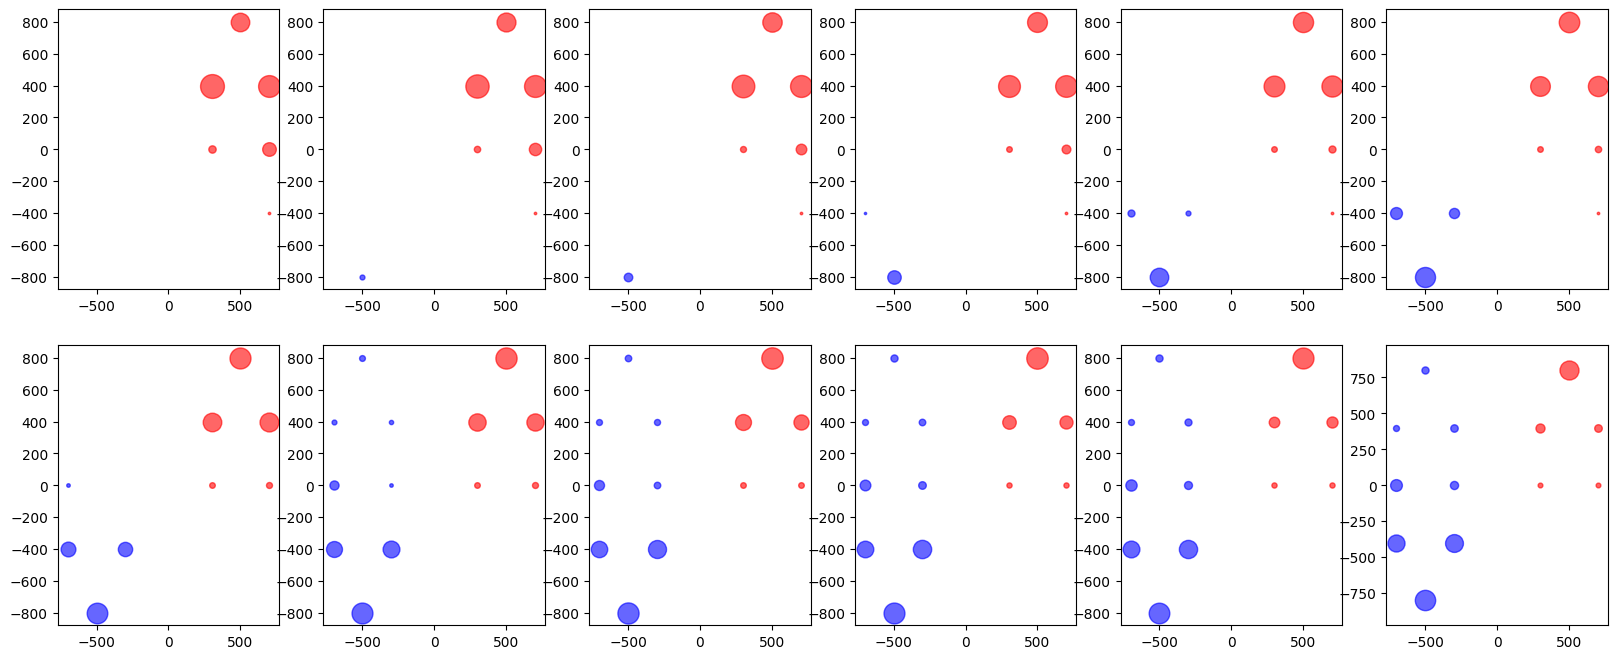

In [212]:
import numpy as np
print("Foot Pressure Distribution")
# Sensor coordinates (from description)
coords_L = [(-500,-800),(-700,-400),(-300,-400),(-700,0),(-300,0),(-700,400),(-300,400),(-500,800)]
coords_R = [(500,-800),(700,-400),(300,-400),(700,0),(300,0),(700,400),(300,400),(500,800)]

plt.figure(figsize=(20,8))
for i in range(1,13):
  row = co_data.iloc[i+1501]

  forces_L = [row[f"L{i}"] for i in range(1,9)]
  #print(forces_L)
  forces_R = [row[f"R{i}"] for i in range(1,9)]

  plt.subplot(2,6,i)

  # Plot left foot sensors
  for (x,y), f in zip(coords_L, forces_L):
      plt.scatter(x, y, s=f, c="blue", alpha=0.6)  # size ~ force

  # Plot right foot sensors
  for (x,y), f in zip(coords_R, forces_R):
      plt.scatter(x, y, s=f, c="red", alpha=0.6)

plt.axis("equal")
plt.show()


Left Foot Sensor Forces for controled health


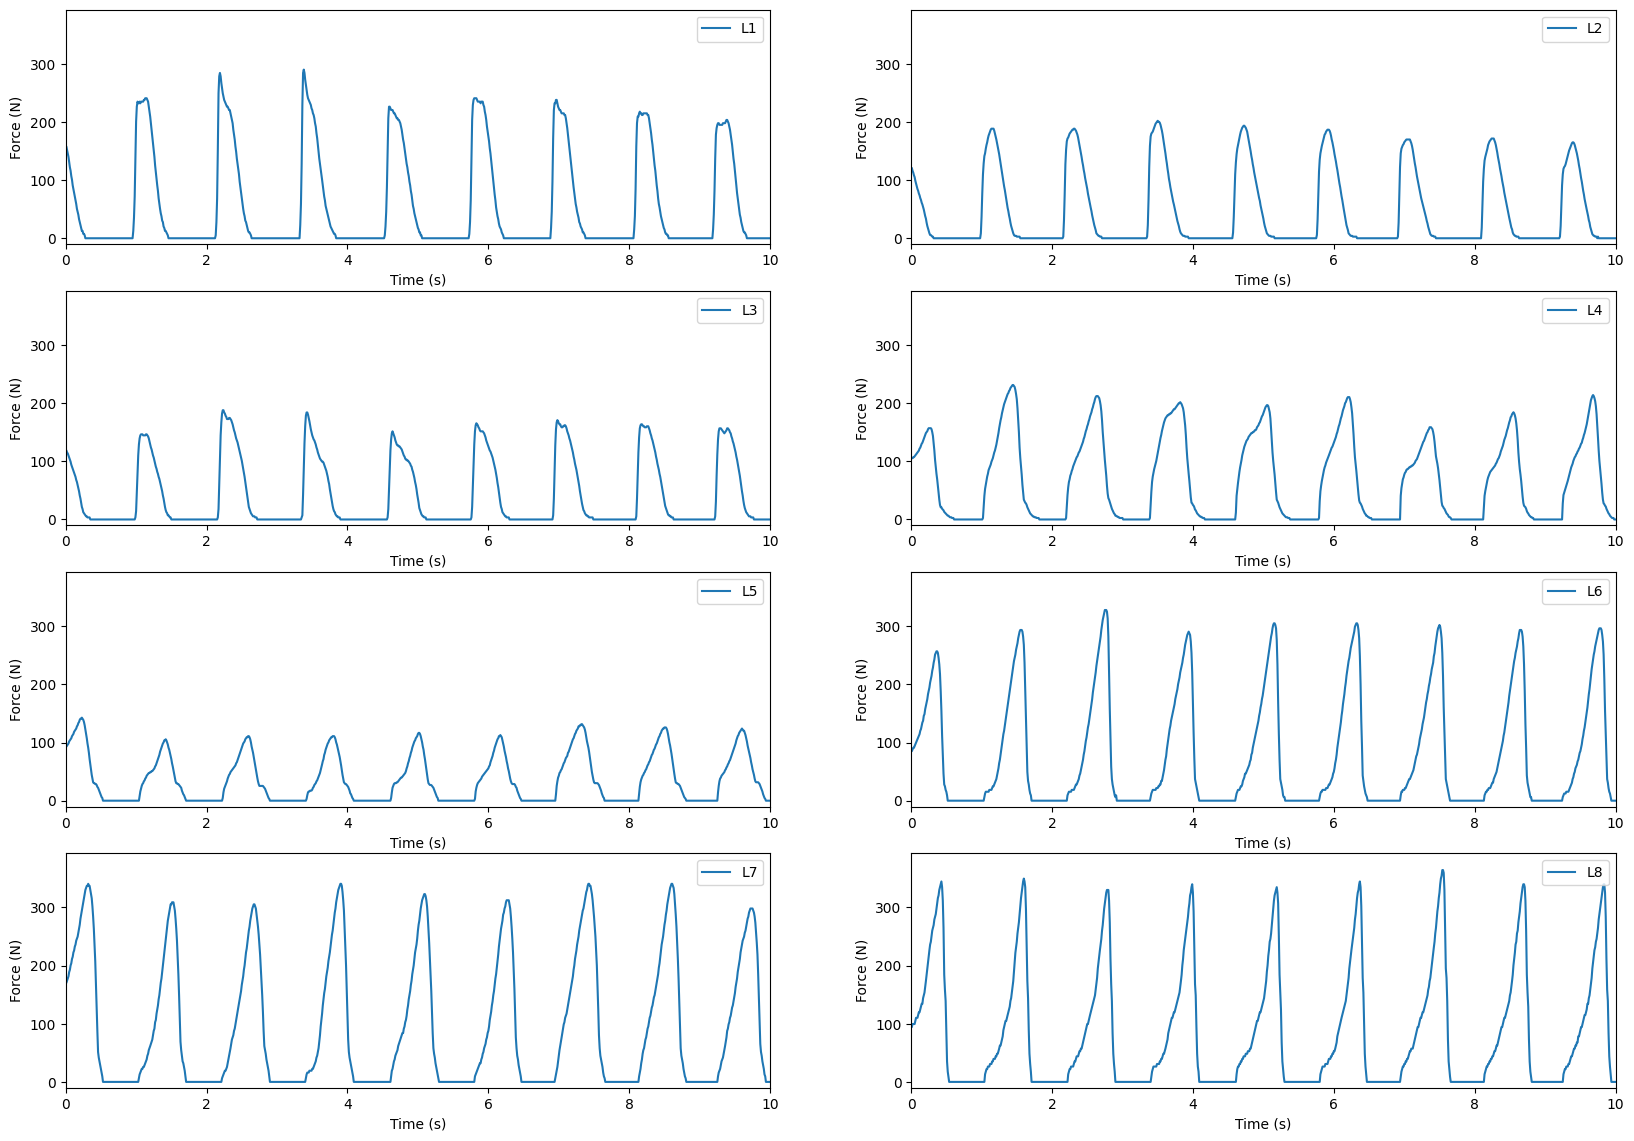

In [213]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,14))
print("Left Foot Sensor Forces for controled health")

# Find the maximum value across all relevant columns
max_force = co_data[['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']].values.max()

# Iterate through each left foot sensor
for i in range(1,9):
  plt.subplot(4,2,i)
  plt.plot(co_data["Time"], co_data[f"L{i}"], label=f"L{i}")
  plt.xlabel("Time (s)")
  plt.ylabel("Force (N)")
  plt.legend(loc='upper right')
  plt.ylim(-10, max_force+10) # Set y-axis limit
  plt.xlim(0,10)
plt.show()

In [214]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


def CVGRF_segmented(files,UPDRS_level, path, window_size=3000) -> pd.DataFrame:
    dataset = []
    label = []
    UPDRS =[]
    id=[]

    for i in files:
        file_path = os.path.join(path, i)
        data = pd.read_csv(file_path, sep='\t', header=None)

        # Determine the label based on filename
        if "Pt" in i:
            file_label = 1  # Parkinson's disease
            updrs=UPDRS_level[i.split('_')[0]]
            if updrs =="nan" or updrs=="NAN":
              updrs=4
            sl=1#severity grading
            if updrs < 5:
                sl = 1
            elif updrs < 15:
                sl = 2
            elif updrs < 25:
                sl = 3
            elif updrs <35:
                sl = 4
            else:
                sl = 5

        elif "Co" in i:
            file_label = 0  # Control
            sl=1

        else:
            # Handle files that don't match "Pt" or "Co" if necessary
            continue

        cm_sum = data.iloc[:, -1] + data.iloc[:, -2]
        cm_sum = cm_sum.values

        # number of full windows
        num_segments = len(cm_sum) // window_size

        for seg in range(num_segments):
            start = seg * window_size
            end = start + window_size
            segment = cm_sum[start:end]
            scaler = MinMaxScaler(feature_range=(-1, 1))
            segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
            #segment = (segment - np.mean(segment)) / np.std(segment)

            dataset.append(segment)
            label.append(file_label)  # Assign the numerical label
            UPDRS.append(sl)
            id.append(i)

    return pd.DataFrame({
        "id":id,
        "signal": dataset,
        "label": label,
        "UPDRS":UPDRS,
    })

In [215]:
import numpy as np
dataset = CVGRF_segmented(files,UPDRS_level,path)
time=co_data['Time']

In [216]:
dataset.head(30)

,id,signal,label,UPDRS
0,GaPt03_01.txt,"[-0.18689903846153832, -0.18689903846153832, -...",1,3
1,GaPt03_01.txt,"[0.6139410187667558, 0.6588471849865947, 0.733...",1,3
2,GaPt03_01.txt,"[-0.38434903047091407, -0.3940443213296394, -0...",1,3
3,GaPt03_01.txt,"[0.02259887005649741, -0.0018832391713745622, ...",1,3
4,SiPt02_01.txt,"[-0.39289920915362586, -0.39289920915362586, -...",1,5
5,SiPt02_01.txt,"[-0.5348925651264498, -0.5911770298535841, -0....",1,5
6,SiPt02_01.txt,"[-0.5443471640654738, -0.4838218500190328, -0....",1,5
7,SiPt02_01.txt,"[0.6553406516814766, 0.6006272869837952, 0.443...",1,5
8,SiPt04_01.txt,"[0.03990055935363612, 0.03990055935363612, 0.0...",1,4
9,SiPt04_01.txt,"[-0.05445724681625208, -0.1090357792601575, -0...",1,4


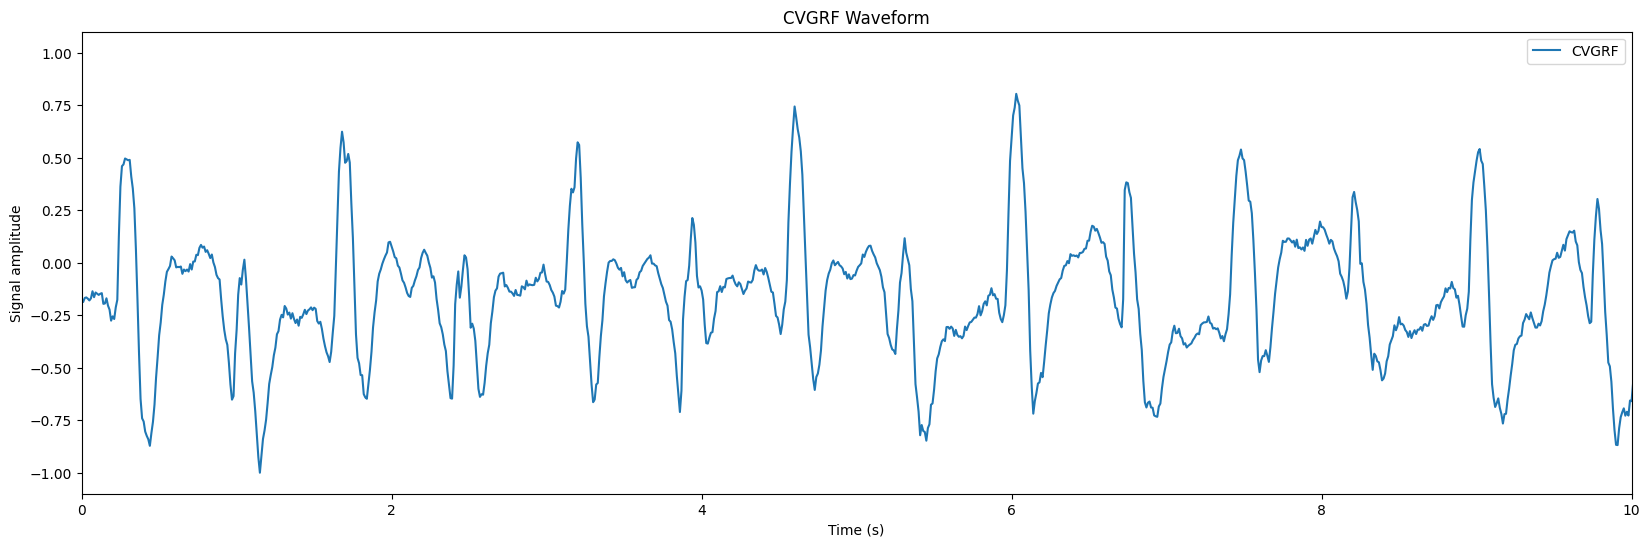

In [217]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Access the first signal from the 'signal' column of the dataset DataFrame
plt.plot(time[0:3000], dataset['signal'][0], label='CVGRF')
plt.title("CVGRF Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Signal amplitude")
plt.legend(ncol=4) # Add ncol for better legend display
plt.xlim(0, 10) # Keep x-axis limit to the first 10 seconds
plt.show()

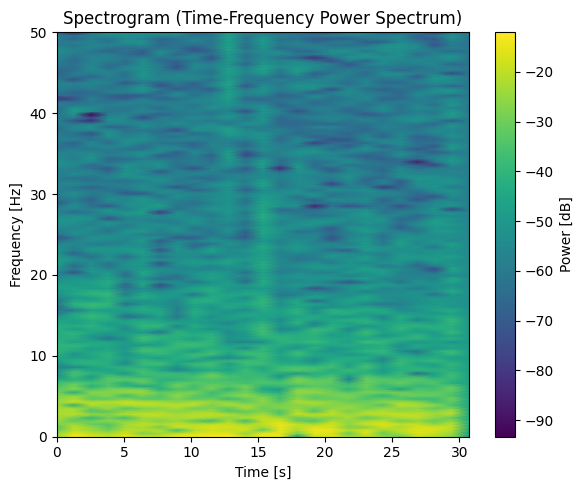

Instantaneous Frequency (per window): 2.0181896624921056
Spectral Entropy (per window): 0.5792326213103817


In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def compute_instFreq(signal, fs, nperseg=None, noverlap=None):
    #Compute single IF using STFT weighted average.
    if nperseg is None:
        nperseg = len(signal)   # use full window
    if noverlap is None:
        noverlap = nperseg // 2

    f, t, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    P = np.abs(Zxx) ** 2
    f_mean_t = np.sum(P * f[:, None], axis=0) / np.sum(P, axis=0)
    IF = np.mean(f_mean_t)   # average over time bins → 1 value per window
    return IF

#max possible SE of frequency-domain
def compute_spectral_entropy(signal):
    #Compute single SE using FFT."""
    fft_vals = np.fft.fft(signal)
    psd = np.abs(fft_vals[:len(signal)//2])**2
    psd /= np.sum(psd) + 1e-12
    SE = -np.sum(psd * np.log2(psd + 1e-12)) / np.log2(len(psd))
    return SE


fs = 100
t = np.linspace(0, 30, 3000, endpoint=False)
x = dataset['signal'][0]

# spectral plot
f, tt, Zxx = stft(x, fs=fs, nperseg=256, noverlap=128)
Pxx = np.abs(Zxx)**2

plt.figure(figsize=(6,5))
plt.pcolormesh(tt, f, 10*np.log10(Pxx), shading='gouraud', cmap='viridis')
plt.colorbar(label="Power [dB]")
plt.title("Spectrogram (Time-Frequency Power Spectrum)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

# Features per window
IF_feature = compute_instFreq(x, fs)
SE_feature = compute_spectral_entropy(x)

print("Instantaneous Frequency (per window):", IF_feature)
print("Spectral Entropy (per window):", SE_feature)

#Recurrence plot
A recurrence plot (whether binary or fuzzy) shows where a system revisits states that are similar to ones it has been in before.

* Diagonal lines → indicate repeating trajectories or deterministic dynamics (predictability).

* Vertical/horizontal lines → indicate states that persist (laminar states, “sticking” behavior).

* Isolated dots → randomness, noise, or very short-lived recurrences.

* Checkerboard-like structures (like in your image) → strong periodicity.


#Epsilon
Epsilon determines the radius around each point in the embedded phase space within which other points are considered "similar" or "recurrent".


In [219]:
import numpy as np


def time_delay_embedding(x, m=3, tau=1, scale='zscore'):

    x = np.asarray(x, dtype=float).copy()

    if scale == 'zscore':
        std = x.std()
        if std > 0:
            x = (x - x.mean()) / std
        else:
            x = x - x.mean()
    elif scale == 'none':
        pass
    else:
        raise ValueError("scale must be 'zscore' or 'none'")

    T = x.shape[0]
    N = T - (m - 1) * tau
    if N <= 0:
        raise ValueError("Time series too short for given m and tau.")

    # Build Hankel-like embedded matrix
    idx = np.arange(m)[:, None] * tau + np.arange(N)[None, :]
    X = x[idx.T]  # shape (N, m)
    return X


def pairwise_distances(X):
    # Broadcasting method: O(N^2 m)
    diff = X[:, None, :] - X[None, :, :]       # (N, N, m)
    D = np.sqrt(np.sum(diff * diff, axis=2))   # (N, N)
    return D


def fuzzy_membership(D, epsilon, kind='rational',mode="fuzzy"):

    if epsilon is None or epsilon <= 0:
        raise ValueError("epsilon must be a positive float.")

    if mode == 'fuzzy':
        if kind == 'rational':
            M = 1.0 / (1.0 + (D / float(epsilon)))
        elif kind == 'gaussian':
            M = np.exp(-(D * D) / (2.0 * float(epsilon) ** 2))
        else:
            raise ValueError("kind must be 'rational' or 'gaussian'")
    elif mode == 'binary':
        # Binary recurrence: 1 if distance <= epsilon else 0
        M = (D <= float(epsilon)).astype(float)
    else:
        raise ValueError("mode must be 'fuzzy' or 'binary'")

    np.fill_diagonal(M, 1.0)  # always 1 on diagonal
    return M

def choose_epsilon(D, quantile=0.10):

    d = D[np.triu_indices_from(D, k=1)]  # upper triangle (exclude diagonal)
    d = d[d > 0]
    if d.size == 0:
        # All points identical; fall back to tiny epsilon
        return 1e-6
    q = np.clip(quantile, 1e-6, 1 - 1e-6)
    eps = np.quantile(d, q)
    if eps <= 0:
        eps = np.maximum(np.median(d), 1e-6)
    return float(eps)


def fuzzy_recurrence_plot(x, m=3, tau=1,epsilon='auto', eps_quantile=0.10, membership='rational', scale='zscore',mode="fuzzy"):

    # Embed
    X = time_delay_embedding(x, m=m, tau=tau, scale=scale)

    # Pairwise distances
    D = pairwise_distances(X)

    # Choose epsilon
    if epsilon == 'auto':
        eps_used = choose_epsilon(D, quantile=eps_quantile)
    else:
        eps_used = float(epsilon)

    # Convert to fuzzy similarities
    FRP = fuzzy_membership(D, eps_used, kind=membership,mode=mode)

    return FRP, X, eps_used



#FRIE
FRIE is just Shannon entropy of the pixel intensity distribution (histogram of values in FRP).
* High FRIE → the FRP has many different intensity levels spread across the image. Complex recurrence patterns, lots of variation in similarity values.

* Low FRIE → the FRP intensities are concentrated in just a few bins. Uniform recurrence (either too ordered or too random).
#FRE
Captures uncertainty in recurrence relations.
* High FRE → maximum uncertainty in recurrenc, the system is ambiguous about whether states are similar or not.
* Low FRE → low uncertainty, system is clearly either recurring or not.

In [220]:
'''More bins → entropy becomes sensitive to noise and sample size.

Fewer bins → entropy overestimates complexity (because details are lost).'''

def fuzzy_recurrence_image_entropy(FRP, bins=64, normalize=True, exclude_diagonal=True):

    M = np.asarray(FRP, dtype=float)

    if exclude_diagonal: #If you include them, the histogram will be biased toward high similarity (1.0).
        mask = ~np.eye(M.shape[0], dtype=bool)
        vals = M[mask]
    else:
        vals = M.ravel()

    # Constrain to [0,1] for safety
    vals = np.clip(vals, 0.0, 1.0)

    # Histogram → probability distribution
    counts, bin_edges = np.histogram(vals, bins=bins, range=(0.0, 1.0))
    total = counts.sum() #total pixcel
    if total == 0:
        # Degenerate case (e.g., empty after masking)
        P = np.zeros_like(counts, dtype=float)
        H = 0.0
        return (H, P, bin_edges)

    P = counts.astype(float) / float(total)

    # Remove zero bins to avoid log(0) (they contribute 0 to the sum)
    nz = P > 0
    FRIE = -np.sum(P[nz] * np.log2(P[nz]))

    if normalize:
        FRIE = FRIE / np.log2(bins)

    return FRIE, P, bin_edges


def fuzzy_recurrence_entropy(FRP, exclude_diagonal=True):
    M = np.asarray(FRP, dtype=float)
    if exclude_diagonal:
        mask = ~np.eye(M.shape[0], dtype=bool)
        vals = M[mask]
    else:
        vals = M.ravel()

    # Clip both terms to avoid log(0)
    vals = np.clip(vals, 1e-12, 1 - 1e-12)
    one_minus_vals = np.clip(1 - vals, 1e-12, 1 - 1e-12)

    term1 = -np.sum(vals * np.log2(vals))
    term2 = -np.sum(one_minus_vals * np.log2(one_minus_vals))

    return (term1 + term2) / (M.shape[0] * M.shape[0])



In [221]:
signal1=dataset['signal'][50]
print("label",dataset['label'][50])

m=3
tau=1
epsilon="auto"
eps_quantile=0.10
membership="rational"
scale="zscore"
mode="fuzzy"


FRP1, X, eps_used = fuzzy_recurrence_plot(signal1, m=m, tau=tau, epsilon=.34, eps_quantile=eps_quantile,membership=membership, scale=scale,mode=mode)
FRIE,P,edge_bins=fuzzy_recurrence_image_entropy(FRP1)
FRE = fuzzy_recurrence_entropy(FRP1)

print("Fuzzy Recurrence Image Entropy:", FRIE)
print("epsilon used:",eps_used)
print("Fuzzy Recurrence Entropy:", FRE)

signal2=dataset['signal'][1029]
print("label",dataset['label'][1029])
FRP2, X, eps_used = fuzzy_recurrence_plot(signal2, m=m, tau=tau, epsilon=.34, eps_quantile=eps_quantile,membership=membership, scale=scale,mode=mode)
FRIE,P,edge_bins=fuzzy_recurrence_image_entropy(FRP2)
FRE = fuzzy_recurrence_entropy(FRP2)
print("Fuzzy Recurrence Image Entropy:", FRIE)
print("epsilon used:",eps_used)
print("Fuzzy Recurrence Entropy:", FRE)

label 1
Fuzzy Recurrence Image Entropy: 0.8238893493961953
epsilon used: 0.34
Fuzzy Recurrence Entropy: 0.6649972707666635
label 0
Fuzzy Recurrence Image Entropy: 0.8000945127777753
epsilon used: 0.34
Fuzzy Recurrence Entropy: 0.6578377485649268


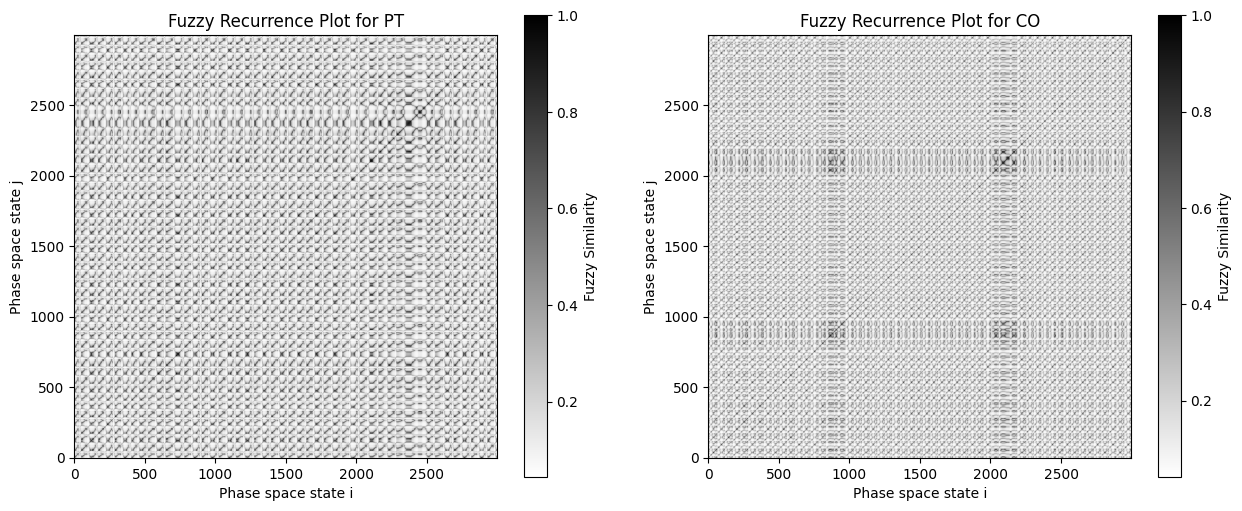

In [222]:
import matplotlib.pyplot as plt
max_value = max(max(row) for row in FRP1)
#0 → white (no recurrence), 1 → black (recurrence).
plt.figure(figsize=(15, 6))
def plot_fuzzy_recurrence_plot(FRP, title="Fuzzy Recurrence Plot"):

    plt.imshow(FRP, cmap='gray_r', origin='lower', extent=[0, FRP.shape[0], 0, FRP.shape[0]])
    plt.title(title)
    plt.xlabel("Phase space state i")
    plt.ylabel("Phase space state j")
    plt.colorbar(label="Fuzzy Similarity")

plt.subplot(1, 2, 1)
plot_fuzzy_recurrence_plot(FRP1, title="Fuzzy Recurrence Plot for PT")

plt.subplot(1, 2, 2)
# previously computed FRP
plot_fuzzy_recurrence_plot(FRP2, title="Fuzzy Recurrence Plot for CO")
plt.show()

In [223]:
def create_feature_dataset(dataset,n_samples=1034, sequence_length=30, fs=100):

    print("extracting features ...")

    # Create CVGRF signals feature
    features_list = []
    labels_list = []
    severity_labels = []


    t = np.linspace(0, sequence_length, sequence_length * fs)
    for i in range(n_samples):
      cvgrf=dataset['signal'][i]

      label = dataset['label'][i]

      updrs = dataset['UPDRS'][i]



      IF=compute_instFreq(cvgrf,fs)
      SE=compute_spectral_entropy(cvgrf)
      FRP, X, eps_used = fuzzy_recurrence_plot(cvgrf, m=m, tau=tau, epsilon="auto", eps_quantile=eps_quantile,membership=membership, scale=scale,mode=mode)
      FRIE,P,edge_bins=fuzzy_recurrence_image_entropy(FRP)
      FRE=fuzzy_recurrence_entropy(FRP)

      features=np.array([IF,SE,FRIE,FRE])

      features_list.append(features)
      labels_list.append(label)
      severity_labels.append(updrs)

      if (i + 1) % 100 == 0:
          print(f"Processed {i + 1}/{n_samples} samples")

    return np.array(features_list), np.array(labels_list),np.array(severity_labels)

In [224]:
X,y,grading=create_feature_dataset(dataset)

extracting features ...
Processed 100/1034 samples
Processed 200/1034 samples
Processed 300/1034 samples
Processed 400/1034 samples
Processed 500/1034 samples
Processed 600/1034 samples
Processed 700/1034 samples
Processed 800/1034 samples
Processed 900/1034 samples
Processed 1000/1034 samples


In [225]:
def visualize_features(features, labels, feature_names=['IF', 'SE', 'FRIE', 'FRE']):
    #Visualize extracted features
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    axes = axes.ravel()

    for i, feature_name in enumerate(feature_names):
        # Separate healthy and PD features
        healthy_features = features[labels == 0, i]
        pd_features = features[labels == 1, i]

        axes[i].hist(healthy_features, alpha=0.6, label='Healthy', bins=30, color='blue')
        axes[i].hist(pd_features, alpha=0.6, label='PD', bins=30, color='red')
        axes[i].set_title(f'{feature_name} Distribution')
        axes[i].set_xlabel(feature_name)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

import torch
from torch.utils.data import Dataset # Import Dataset
class PDDataset(Dataset): # Inherit from Dataset
    #Custom Dataset class for Parkinson's Disease data

    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

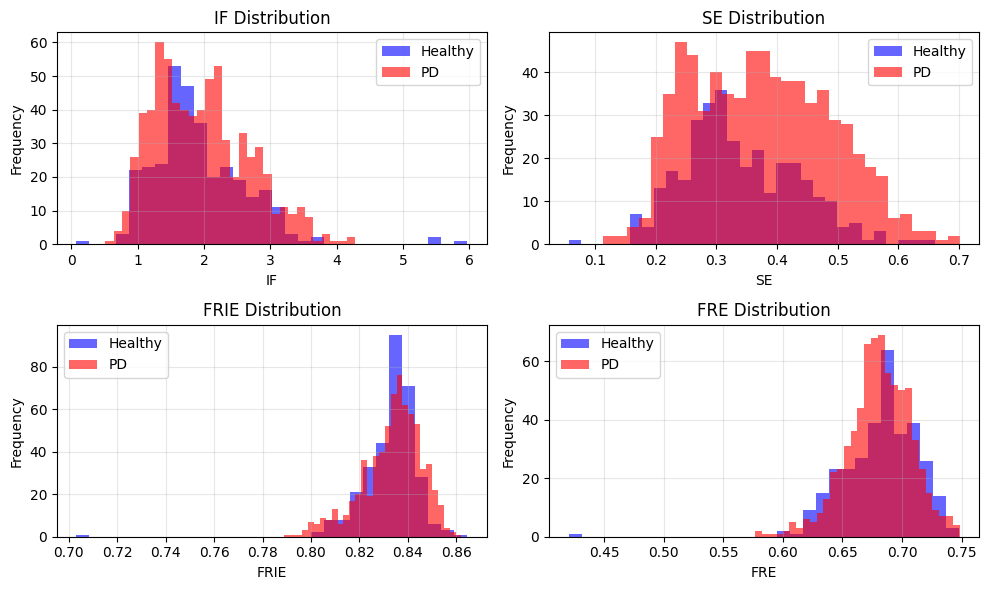

In [226]:
visualize_features(X,y)

In [227]:
class UniLSTM(nn.Module):
    # Uni-directional LSTM model

    def __init__(self,hidden_size, input_size=4, num_layers=2, num_classes=2):
        super(UniLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = self.dropout(lstm_out[:, -1, :])
        #out = self.dropout(torch.mean(lstm_out, dim=1))
        out = self.fc(out)

        return out

class BiLSTM(nn.Module):
    # Bi-directional LSTM model

    def __init__(self, hidden_size,input_size, num_layers=2, num_classes=2):
        super(BiLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = self.dropout(lstm_out[:, -1, :])
        #out = self.dropout(torch.mean(lstm_out, dim=1))

        out = self.fc(out)

        return out


In [228]:
class BayesianOptimizer:
    # Simple Bayesian Optimization for hyperparameter tuning

    def __init__(self, lr_bounds=(0.001, 1.0), hidden_bounds=(50, 120),num_classes=2, n_iterations=20):
        self.lr_bounds = lr_bounds
        self.hidden_bounds = hidden_bounds
        self.n_iterations = n_iterations
        self.history = []
        self.num_classes=num_classes


    def objective_function(self, lr, hidden_units, model_type, train_loader, val_loader):
        # Objective function to minimize (validation loss)
        input_size = 4
        num_classes = self.num_classes

        if model_type == 'uni':
            model = UniLSTM( int(hidden_units),input_size, num_classes=num_classes)
        else:
            model = BiLSTM( int(hidden_units),input_size, num_classes=num_classes)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Quick training for optimization
        model.train()
        total_loss = 0
        for epoch in range(5):  # Limited epochs for optimization
            for batch_features, batch_labels in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

        return val_loss / len(val_loader)

    def optimize(self, model_type, train_loader, val_loader):
        # Simple grid search optimization (simplified Bayesian optimization)
        best_loss = float('inf')
        best_params = {}

        # Grid search over parameter space
        lr_values = np.logspace(np.log10(self.lr_bounds[0]), np.log10(self.lr_bounds[1]), 10)
        hidden_values = np.linspace(self.hidden_bounds[0], self.hidden_bounds[1], 8, dtype=int)

        iteration = 0
        for lr in lr_values:
            for hidden in hidden_values:
                if iteration >= self.n_iterations:
                    break

                loss = self.objective_function(lr, hidden, model_type, train_loader, val_loader)
                self.history.append({'iteration': iteration, 'lr': lr, 'hidden': hidden, 'loss': loss})

                if loss < best_loss:
                    best_loss = loss
                    best_params = {'lr': lr, 'hidden_units': int(hidden)}

                print(f"Iteration {iteration+1}/{self.n_iterations}: LR={lr:.4f}, Hidden={hidden}, Loss={loss:.4f}")
                iteration += 1

            if iteration >= self.n_iterations:
                break

        return best_params, best_loss


In [229]:
def visualize_bayesian_optimization(history):
    # Visualize Bayesian optimization progress
    if not history:
        print("No optimization history to visualize")
        return

    iterations = [h['iteration'] for h in history]
    losses = [h['loss'] for h in history]
    lrs = [h['lr'] for h in history]
    hiddens = [h['hidden'] for h in history]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss over iterations
    axes[0, 0].plot(iterations, losses, 'b-o', markersize=3)
    axes[0, 0].set_title('Objective Function (Validation Loss)')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)

    # Learning rate vs loss
    axes[0, 1].scatter(lrs, losses, c=iterations, cmap='viridis', alpha=0.7)
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_title('Learning Rate vs Loss')
    axes[0, 1].set_xlabel('Learning Rate')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)

    # Hidden units vs loss
    axes[1, 0].scatter(hiddens, losses, c=iterations, cmap='viridis', alpha=0.7)
    axes[1, 0].set_title('Hidden Units vs Loss')
    axes[1, 0].set_xlabel('Hidden Units')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # 3D scatter plot showing both parameters
    ax = axes[1, 1]
    scatter = ax.scatter(lrs, hiddens, c=losses, cmap='coolwarm', s=50, alpha=0.7)
    ax.set_xscale('log')
    ax.set_title('Parameter Space Exploration')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Hidden Units')
    plt.colorbar(scatter, ax=ax, label='Loss')

    plt.tight_layout()
    plt.show()


In [230]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
 # Reshape features to create sequences (each sample becomes a sequence of length 1 with 4 features)
#features_seq = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\nDataset splits:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")
mean=X_train.mean(axis=0)
std=X_train.std(axis=0)

X_train=(X_train-mean)/std
X_val=(X_val-mean)/std
X_test=(X_test-mean)/std


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val   = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Create data loaders
train_dataset = PDDataset(X_train, y_train)
val_dataset = PDDataset(X_val, y_val)
test_dataset = PDDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Dataset splits:
Train: 620 samples
Validation: 207 samples
Test: 207 samples


In [231]:
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, lr=0.001, epochs=80,patience=10):
    # Train and evaluate the model with extended metrics
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    print(f"Training {model.__class__.__name__}...")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        # --- Early stopping check ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        if best_model_state:
         model.load_state_dict(best_model_state)
    # Test evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for PD class
            _, predicted = torch.max(outputs.data, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)  # Sensitivity
    f1 = f1_score(all_labels, all_preds)

    # Confusion matrix for specificity
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    balanced_accuracy = (recall + specificity) / 2

    # ROC AUC
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nTest Results for {model.__class__.__name__}:")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Sensitivity(recall)    : {recall:.4f}")  # recall
    print(f"Specificity    : {specificity:.4f}")
    print(f"F1-Score       : {f1:.4f}")
    print(f"Balanced Acc.  : {balanced_accuracy:.4f}")
    print(f"AUC            : {auc:.4f}")

    # --- Visualization ---
    plt.figure(figsize=(15, 5))

    # Training curves
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model.__class__.__name__} Training Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confusion matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'PD'], yticklabels=['Healthy', 'PD'])
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve
    plt.subplot(1, 3, 3)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model.__class__.__name__} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'balanced_accuracy': balanced_accuracy,
        'f1': f1,
        'auc': auc,
        'train_losses': train_losses,
        'val_losses': val_losses
    }


Bayesian Optimization for UniLSTM ===
Iteration 1/20: LR=0.0010, Hidden=50, Loss=0.6236
Iteration 2/20: LR=0.0010, Hidden=60, Loss=0.6256
Iteration 3/20: LR=0.0010, Hidden=70, Loss=0.6240
Iteration 4/20: LR=0.0010, Hidden=80, Loss=0.6307
Iteration 5/20: LR=0.0010, Hidden=90, Loss=0.6247
Iteration 6/20: LR=0.0010, Hidden=100, Loss=0.6277
Iteration 7/20: LR=0.0010, Hidden=110, Loss=0.6285
Iteration 8/20: LR=0.0010, Hidden=120, Loss=0.6265
Iteration 9/20: LR=0.0022, Hidden=50, Loss=0.6196
Iteration 10/20: LR=0.0022, Hidden=60, Loss=0.6292
Iteration 11/20: LR=0.0022, Hidden=70, Loss=0.6146
Iteration 12/20: LR=0.0022, Hidden=80, Loss=0.6165
Iteration 13/20: LR=0.0022, Hidden=90, Loss=0.6092
Iteration 14/20: LR=0.0022, Hidden=100, Loss=0.6165
Iteration 15/20: LR=0.0022, Hidden=110, Loss=0.6045
Iteration 16/20: LR=0.0022, Hidden=120, Loss=0.5954
Iteration 17/20: LR=0.0046, Hidden=50, Loss=0.5807
Iteration 18/20: LR=0.0046, Hidden=60, Loss=0.5811
Iteration 19/20: LR=0.0046, Hidden=70, Loss=0.5

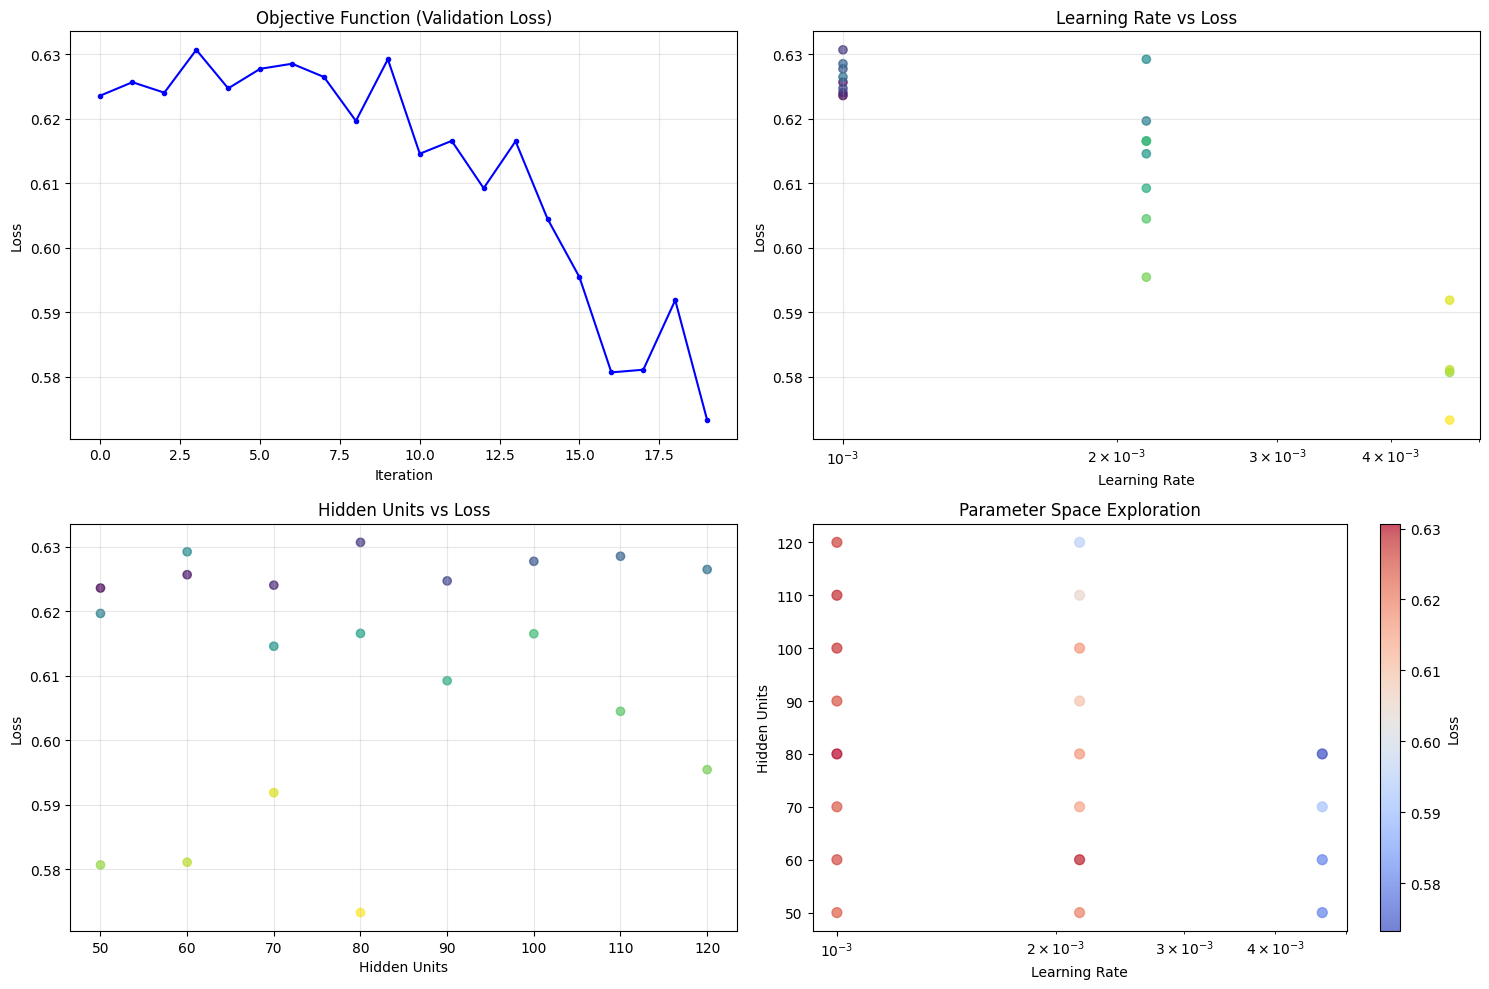

In [232]:
print("Bayesian Optimization for UniLSTM ===")
optimizer_uni=BayesianOptimizer(n_iterations=20)
best_params_uni, best_loss_uni = optimizer_uni.optimize('uni', train_loader, val_loader)
print(f"\nBest parameters for UniLSTM: {best_params_uni}")
visualize_bayesian_optimization(optimizer_uni.history)

Training UNILSTM Models ===
Training UniLSTM...
Epoch [20/80], Train Loss: 0.5500, Val Loss: 0.5431
Early stopping at epoch 29

Test Results for UniLSTM:
Accuracy       : 0.7295
Precision      : 0.7326
Sensitivity(recall)    : 0.9580
Specificity    : 0.2188
F1-Score       : 0.8303
Balanced Acc.  : 0.5884
AUC            : 0.6644


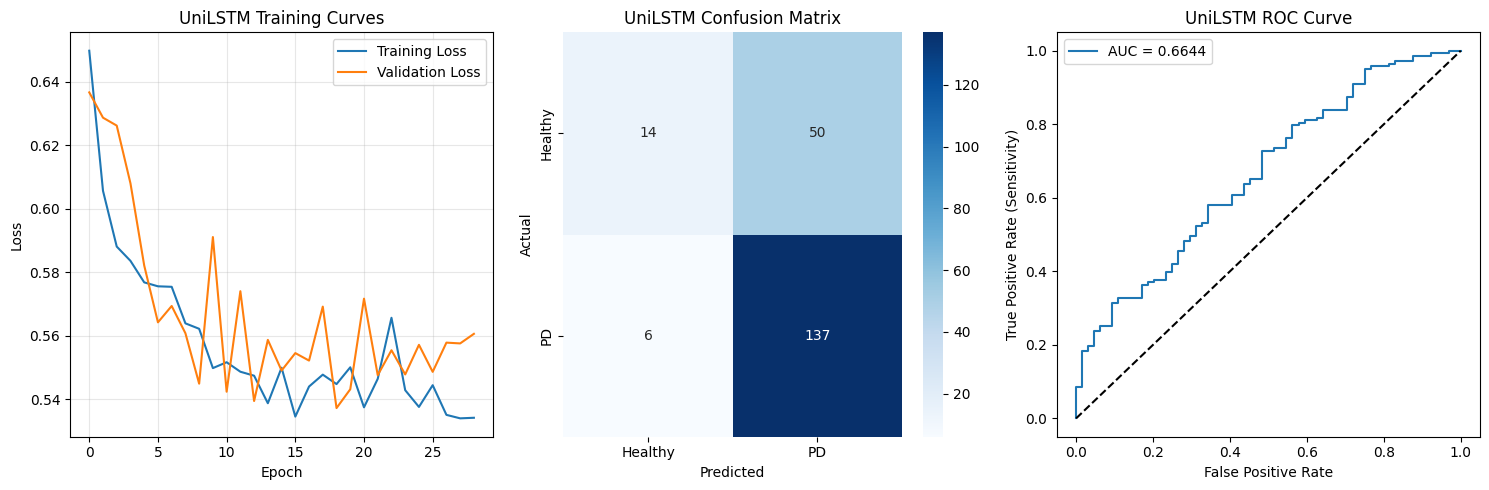

UniLSTM - Accuracy: 0.7295, F1: 0.8303


In [233]:
# Train LSTM models with optimized parameters
print("Training UNILSTM Models ===")

# UniLSTM with optimized parameters
uni_model = UniLSTM(input_size=4, hidden_size=best_params_uni['hidden_units'], num_classes=2)
uni_results = train_and_evaluate_model(uni_model, train_loader, val_loader, test_loader,
                                      lr=best_params_uni['lr'], epochs=80)

print(f"UniLSTM - Accuracy: {uni_results['accuracy']:.4f}, F1: {uni_results['f1']:.4f}")


Bayesian Optimization for BiLSTM ===
Iteration 1/20: LR=0.0010, Hidden=50, Loss=0.6226
Iteration 2/20: LR=0.0010, Hidden=60, Loss=0.6186
Iteration 3/20: LR=0.0010, Hidden=70, Loss=0.6182
Iteration 4/20: LR=0.0010, Hidden=80, Loss=0.6221
Iteration 5/20: LR=0.0010, Hidden=90, Loss=0.6198
Iteration 6/20: LR=0.0010, Hidden=100, Loss=0.6133
Iteration 7/20: LR=0.0010, Hidden=110, Loss=0.6136
Iteration 8/20: LR=0.0010, Hidden=120, Loss=0.6129
Iteration 9/20: LR=0.0022, Hidden=50, Loss=0.5886
Iteration 10/20: LR=0.0022, Hidden=60, Loss=0.5924
Iteration 11/20: LR=0.0022, Hidden=70, Loss=0.5920
Iteration 12/20: LR=0.0022, Hidden=80, Loss=0.5864
Iteration 13/20: LR=0.0022, Hidden=90, Loss=0.6097
Iteration 14/20: LR=0.0022, Hidden=100, Loss=0.5751
Iteration 15/20: LR=0.0022, Hidden=110, Loss=0.5866
Iteration 16/20: LR=0.0022, Hidden=120, Loss=0.5814
Iteration 17/20: LR=0.0046, Hidden=50, Loss=0.5585
Iteration 18/20: LR=0.0046, Hidden=60, Loss=0.5595
Iteration 19/20: LR=0.0046, Hidden=70, Loss=0.60

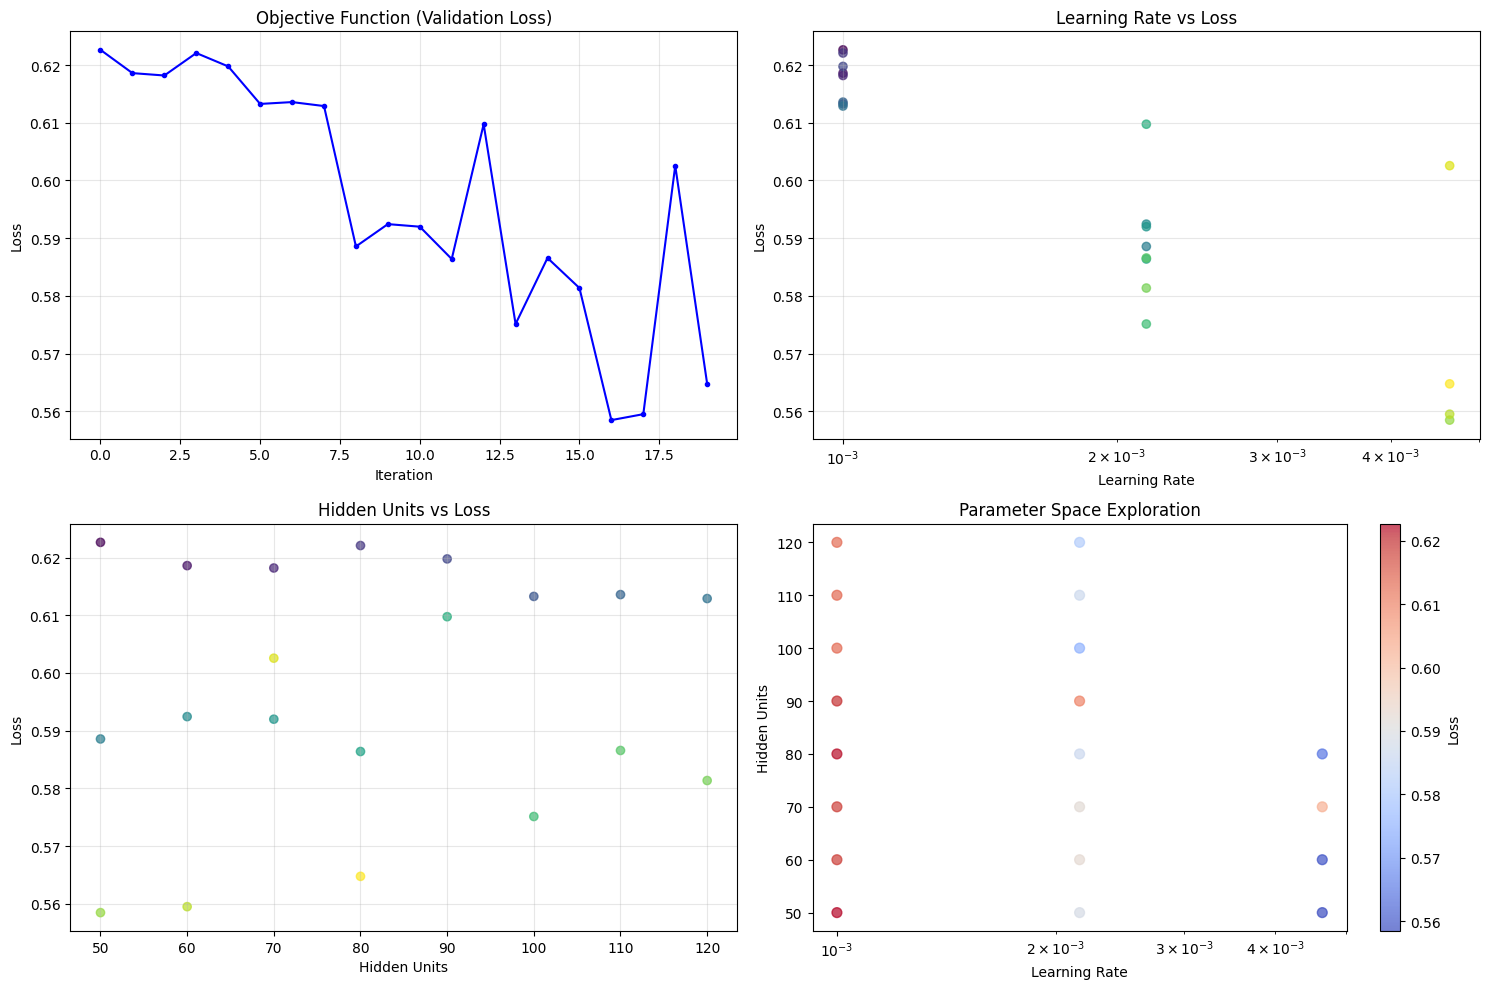

In [234]:
# Bayesian Optimization for BiLSTM
print("Bayesian Optimization for BiLSTM ===")
optimizer_bi = BayesianOptimizer(n_iterations=20)
best_params_bi, best_loss_bi = optimizer_bi.optimize('bi', train_loader, val_loader)
print(f"\nBest parameters for BiLSTM: {best_params_bi}")
print(f"Best validation loss: {best_loss_bi:.4f}")

# Visualize optimization
visualize_bayesian_optimization(optimizer_bi.history)

Training BiLSTM...
Epoch [20/80], Train Loss: 0.5460, Val Loss: 0.5714
Early stopping at epoch 27

Test Results for BiLSTM:
Accuracy       : 0.7150
Precision      : 0.7234
Sensitivity(recall)    : 0.9510
Specificity    : 0.1875
F1-Score       : 0.8218
Balanced Acc.  : 0.5693
AUC            : 0.6616


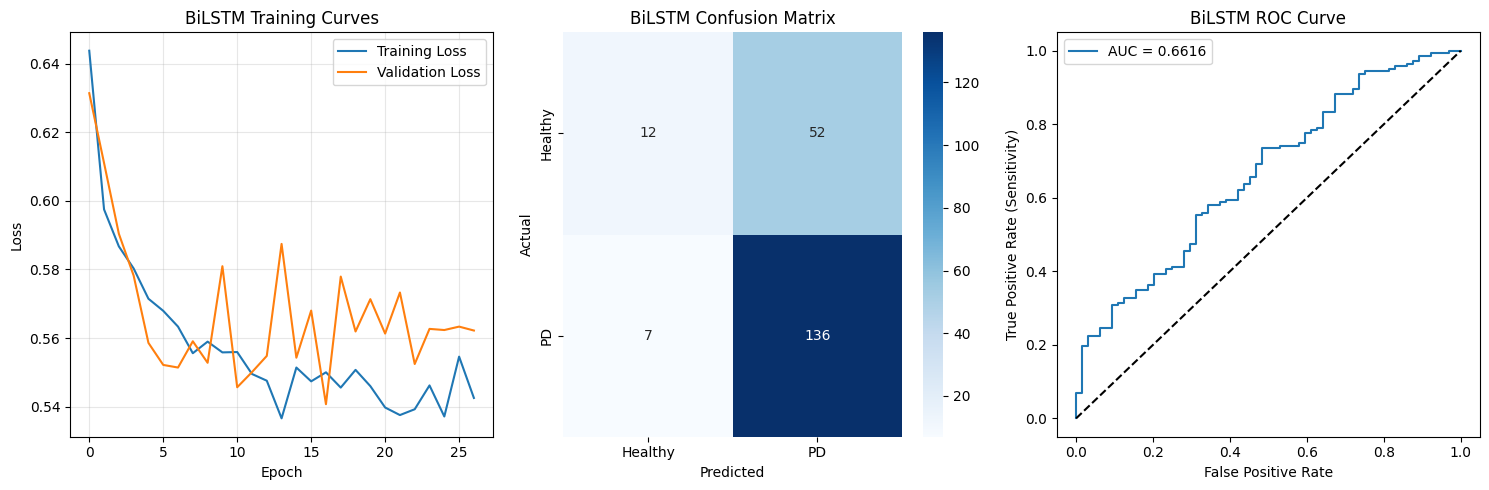

BiLSTM - Accuracy: 0.7150, F1: 0.8218


In [235]:
# training BiLSTM with optimized parameters
bi_model = BiLSTM(input_size=4, hidden_size=best_params_bi['hidden_units'], num_classes=2)
bi_results = train_and_evaluate_model(bi_model, train_loader, val_loader, test_loader,
                                    lr=best_params_bi['lr'], epochs=80)
print(f"BiLSTM - Accuracy: {bi_results['accuracy']:.4f}, F1: {bi_results['f1']:.4f}")

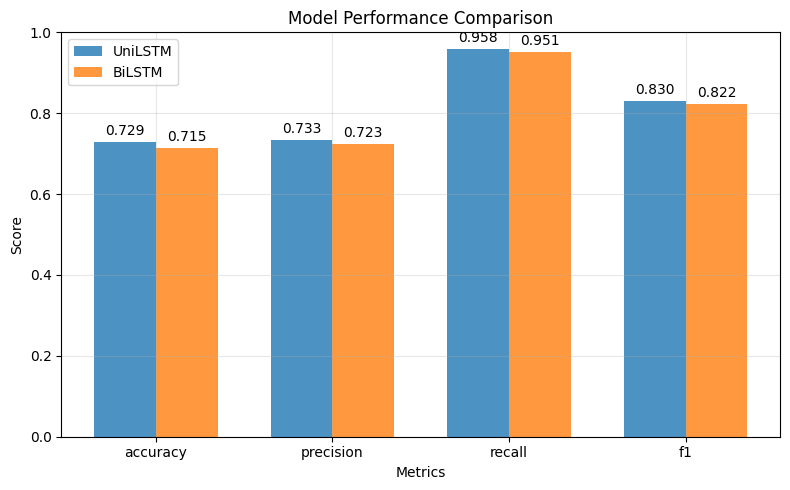

In [236]:
# Plot comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
uni_values = [uni_results[m] for m in metrics]
bi_values = [bi_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, uni_values, width, label='UniLSTM', alpha=0.8)
plt.bar(x + width/2, bi_values, width, label='BiLSTM', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

for i, (uni_val, bi_val) in enumerate(zip(uni_values, bi_values)):
    plt.text(i - width/2, uni_val + 0.01, f'{uni_val:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, bi_val + 0.01, f'{bi_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


#Severity Grading

In [237]:
import pandas as pd

# Create DataFrame for features (name them properly)
df = pd.DataFrame(X, columns=['f1', 'f2', 'f3', 'f4'])
df["label"]=dataset['UPDRS']
#df = df[df['label'] != 0]
df

,f1,f2,f3,f4,label
0,2.018190,0.579233,0.840730,0.714966,3
1,1.801492,0.530155,0.838885,0.713299,3
2,1.841436,0.603933,0.837497,0.709883,3
3,2.064468,0.523586,0.841664,0.709119,3
4,0.950675,0.203282,0.849755,0.647760,5
...,...,...,...,...,...
1029,2.384916,0.437747,0.835505,0.724118,1
1030,2.817253,0.485010,0.828283,0.696006,1
1031,2.525179,0.446471,0.822856,0.672536,1
1032,1.998712,0.365389,0.822558,0.677711,1


In [238]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

feature = df[['f1', 'f2', 'f3', 'f4']]
label = df['label']     # values from 1 to 5

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature)

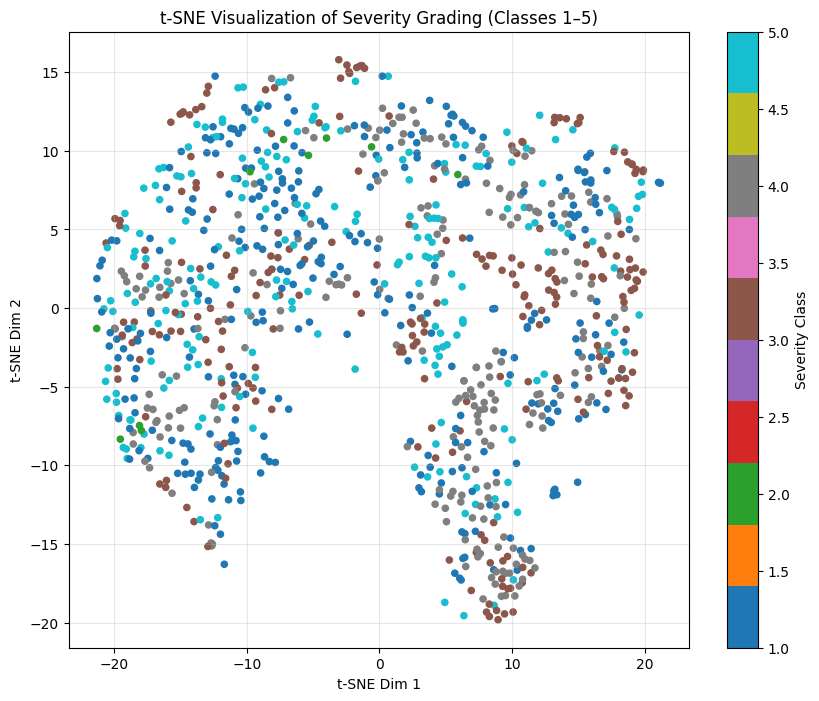

In [239]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=70, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualization
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=label, cmap='tab10', s=20)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Visualization of Severity Grading (Classes 1–5)")
plt.colorbar(scatter, label="Severity Class")
plt.grid(True, alpha=0.3)
plt.show()

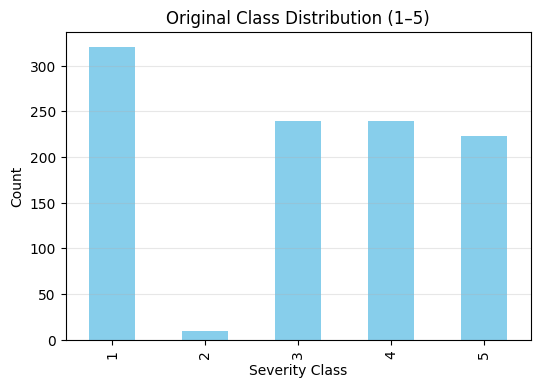

In [240]:
plt.figure(figsize=(6,4))
label.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Original Class Distribution (1–5)")
plt.xlabel("Severity Class")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [241]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def ADASYN_SOMET(X, y, K=5, beta=1.0, d_threshold=0.8):
    X = np.array(X)
    y = np.array(y)

    # Identify minority and majority classes
    classes, counts = np.unique(y, return_counts=True)
    minority_class = classes[np.argmin(counts)]
    majority_class = classes[np.argmax(counts)]

    X_min = X[y == minority_class]
    X_maj = X[y == majority_class]

    ms = len(X_min)
    ml = len(X_maj)

    # ------------------------------------------------------
    # (1) Degree of class imbalance
    # ------------------------------------------------------
    d = ms / ml

    if d >= d_threshold:
        print("Imbalance not severe enough. No ADASYN needed.")
        return X, y

    # ------------------------------------------------------
    # (2a) Number of synthetic samples needed
    # ------------------------------------------------------
    G = int((ml - ms) * beta)

    # ------------------------------------------------------
    # (2b) Compute r_i for each minority sample
    # ------------------------------------------------------
    nn = NearestNeighbors(n_neighbors=K+1).fit(X)
    distances, indices = nn.kneighbors(X_min)

    r = []

    for i in range(ms):
        neighbor_labels = y[indices[i][1:]]      # skip self at index 0
        Δ_i = np.sum(neighbor_labels == majority_class)  # majority neighbors
        r_i = Δ_i / K
        r.append(r_i)

    r = np.array(r)

    # ------------------------------------------------------
    # (2c) Normalize r_i → r_hat_i
    # ------------------------------------------------------
    if r.sum() == 0:
        # All neighbors are minority; cannot generate meaningful ADASYN samples
        r_hat = np.ones(ms) / ms
    else:
        r_hat = r / r.sum()

    # ------------------------------------------------------
    # (2d) Number of synthetic samples per minority point
    # ------------------------------------------------------
    g_i = np.round(r_hat * G).astype(int)

    # ------------------------------------------------------
    # (2e) Generate synthetic samples
    # ------------------------------------------------------
    synthetic_samples = []

    for i in range(ms):
        for _ in range(g_i[i]):
            # Choose 1 minority neighbor randomly
            # indices[i][1:] gives nearest neighbors except self
            minority_neighbors = [idx for idx in indices[i][1:] if y[idx] == minority_class]

            if len(minority_neighbors) == 0:
                continue  # no minority neighbor found

            z = np.random.choice(minority_neighbors)
            x_i = X_min[i]
            x_z = X[z]

            λ = np.random.rand()  # random number [0,1]
            s_i = x_i + (x_z - x_i) * λ

            synthetic_samples.append(s_i)

    # Combine
    synthetic_samples = np.array(synthetic_samples)
    y_syn = np.array([minority_class] * len(synthetic_samples))

    # Return final dataset
    X_new = np.vstack((X, synthetic_samples))
    y_new = np.hstack((y, y_syn))

    return X_new, y_new


In [242]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def adasyn(X, y, k=5):
    X = np.array(X)
    y = np.array(y)

    unique_classes, counts = np.unique(y, return_counts=True)
    majority_class = unique_classes[np.argmax(counts)]
    max_count = np.max(counts)

    X_new = [X.copy()]
    y_new = [y.copy()]

    for cls in unique_classes:
        if cls == majority_class:
            continue

        X_min = X[y == cls]
        needed = max_count - X_min.shape[0]

        if needed <= 0:
            continue

        nn = NearestNeighbors(n_neighbors=k).fit(X)
        _, idx = nn.kneighbors(X_min)

        densities = []
        for i in range(len(X_min)):
            neighbors = y[idx[i]]
            maj_neighbors = np.sum(neighbors != cls)
            densities.append(maj_neighbors / k)

        densities = np.array(densities)
        densities = densities / densities.sum()

        N_synthetic = (densities * needed).astype(int)

        synthetic_samples = []
        for i, n in enumerate(N_synthetic):
            for _ in range(n):
                # Check if there are neighbors to pick from
                if len(idx[i]) > 0: # Ensure there's at least one neighbor
                    neighbor_idx = np.random.choice(idx[i])
                    diff = X[neighbor_idx] - X_min[i]
                    gap = np.random.rand()
                    synthetic_samples.append(X_min[i] + gap * diff)

        # Only append if synthetic_samples is not empty
        if len(synthetic_samples) > 0:
            X_new.append(np.array(synthetic_samples))
            y_new.append(np.array([cls] * len(synthetic_samples)))

    X_final = np.vstack(X_new)
    y_final = np.hstack(y_new)

    return X_final, y_final

In [243]:
def borderline_smote(X, y, k=5):
    X = np.array(X)
    y = np.array(y)

    unique_classes, counts = np.unique(y, return_counts=True)
    majority_class = unique_classes[np.argmax(counts)]
    max_count = np.max(counts)

    X_new = [X.copy()]
    y_new = [y.copy()]

    for cls in unique_classes:
        if cls == majority_class:
            continue

        X_min = X[y == cls]
        needed = max_count - X_min.shape[0]
        if needed <= 0:
            continue

        nn = NearestNeighbors(n_neighbors=k).fit(X)
        _, idx = nn.kneighbors(X_min)

        danger_indices = []
        for i in range(len(X_min)):
            neighbors_y = y[idx[i]]
            maj = np.sum(neighbors_y != cls)
            if maj > k/2:
                danger_indices.append(i)

        danger_samples = X_min[danger_indices]
        synthetic = []

        for _ in range(needed):
            i = np.random.choice(len(danger_samples))
            sample = danger_samples[i]

            # choose a minority neighbor
            nn_idx = np.random.choice(np.where(y == cls)[0])
            diff = X[nn_idx] - sample
            gap = np.random.rand()
            synthetic.append(sample + gap * diff)

        X_new.append(np.array(synthetic))
        y_new.append(np.array([cls] * len(synthetic)))

    return np.vstack(X_new), np.hstack(y_new)


In [244]:
def basic_smote(X, y, k=5):
    X = np.array(X)
    y = np.array(y)

    unique_classes, counts = np.unique(y, return_counts=True)
    majority_class = unique_classes[np.argmax(counts)]
    max_count = np.max(counts)

    X_new = [X.copy()]
    y_new = [y.copy()]

    for cls in unique_classes:
        if cls == majority_class:
            continue
        X_min = X[y == cls]
        needed = max_count - X_min.shape[0]

        nn = NearestNeighbors(n_neighbors=k).fit(X_min)
        _, idx = nn.kneighbors(X_min)

        synthetic = []
        for _ in range(needed):
            i = np.random.randint(len(X_min))
            neighbor = X_min[idx[i][np.random.randint(1, k)]]
            diff = neighbor - X_min[i]
            gap = np.random.rand()
            synthetic.append(X_min[i] + gap * diff)

        X_new.append(np.array(synthetic))
        y_new.append(np.array([cls]*len(synthetic)))

    return np.vstack(X_new), np.hstack(y_new)


In [245]:
def enn_cleaning(X, y, k=3):
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, idx = nn.kneighbors(X)

    keep_mask = []
    for i in range(len(X)):
        neighbors = y[idx[i][1:]]
        if (neighbors == y[i]).sum() >= (k/2):
            keep_mask.append(True)
        else:
            keep_mask.append(False)

    return X[keep_mask], y[keep_mask]


1    321
2    321
3    321
4    321
5    321
Name: count, dtype: int64


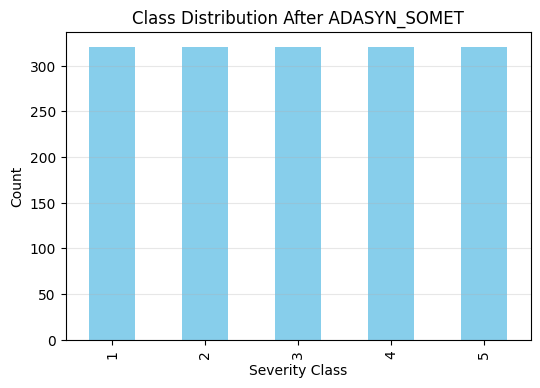

In [246]:
new_x,new_y=ADASYN_SOMET(X_scaled,label)
X_scale = scaler.fit_transform(new_x)
new_x,new_y=borderline_smote(X_scale,new_y)
plt.figure(figsize=(6,4))
print(pd.Series(new_y).value_counts().sort_index())
pd.Series(new_y).value_counts().sort_index().plot(kind='bar', color='skyblue') # Convert to Pandas Series
plt.title("Class Distribution After ADASYN_SOMET") # Changed title for clarity
plt.xlabel("Severity Class")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

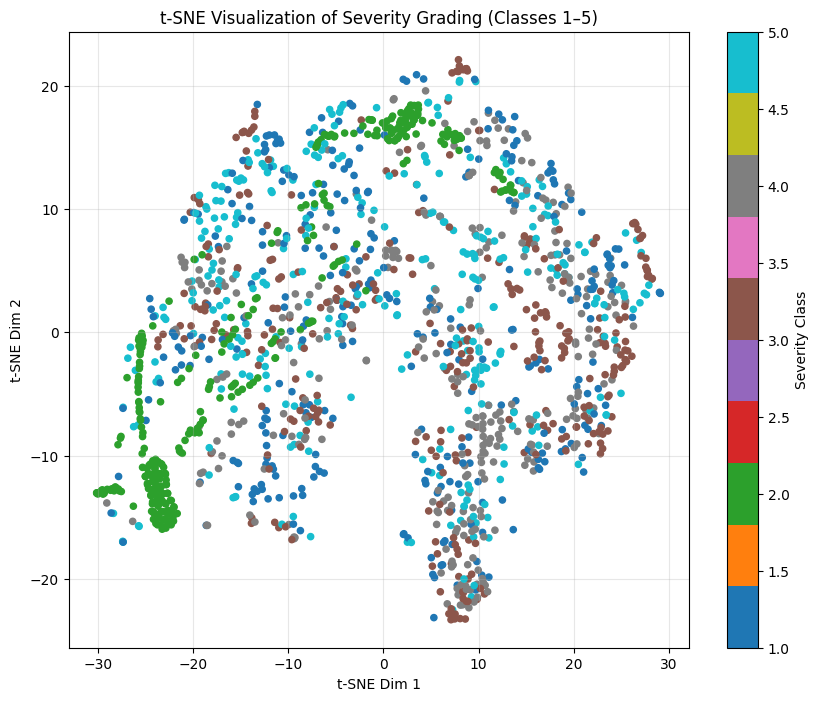

In [247]:
X_scale = scaler.fit_transform(new_x)

tsne = TSNE(n_components=2, perplexity=70, random_state=42)
X_tsne = tsne.fit_transform(X_scale)

# Visualization
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=new_y, cmap='tab10', s=20)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Visualization of Severity Grading (Classes 1–5)")
plt.colorbar(scatter, label="Severity Class")
plt.grid(True, alpha=0.3)
plt.show()

In [248]:

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_scale, new_y, test_size=0.2, random_state=42, stratify=new_y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Adjust labels to be 0-indexed for CrossEntropyLoss
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

# Reshape features to create sequences (each sample becomes a sequence of length 1 with 4 features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val   = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Create data loaders
train_dataset = PDDataset(X_train, y_train)
val_dataset = PDDataset(X_val, y_val)
test_dataset = PDDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(963, 1, 4)
(321, 1, 4)
(321, 1, 4)


Bayesian Optimization for UniLSTM ===
Iteration 1/20: LR=0.0010, Hidden=50, Loss=1.5039
Iteration 2/20: LR=0.0010, Hidden=60, Loss=1.4967
Iteration 3/20: LR=0.0010, Hidden=70, Loss=1.5089
Iteration 4/20: LR=0.0010, Hidden=80, Loss=1.4931
Iteration 5/20: LR=0.0010, Hidden=90, Loss=1.4972
Iteration 6/20: LR=0.0010, Hidden=100, Loss=1.4881
Iteration 7/20: LR=0.0010, Hidden=110, Loss=1.4919
Iteration 8/20: LR=0.0010, Hidden=120, Loss=1.4814
Iteration 9/20: LR=0.0022, Hidden=50, Loss=1.4630
Iteration 10/20: LR=0.0022, Hidden=60, Loss=1.4518
Iteration 11/20: LR=0.0022, Hidden=70, Loss=1.4423
Iteration 12/20: LR=0.0022, Hidden=80, Loss=1.4399
Iteration 13/20: LR=0.0022, Hidden=90, Loss=1.4205
Iteration 14/20: LR=0.0022, Hidden=100, Loss=1.4360
Iteration 15/20: LR=0.0022, Hidden=110, Loss=1.4213
Iteration 16/20: LR=0.0022, Hidden=120, Loss=1.4211
Iteration 17/20: LR=0.0046, Hidden=50, Loss=1.3954
Iteration 18/20: LR=0.0046, Hidden=60, Loss=1.3920
Iteration 19/20: LR=0.0046, Hidden=70, Loss=1.3

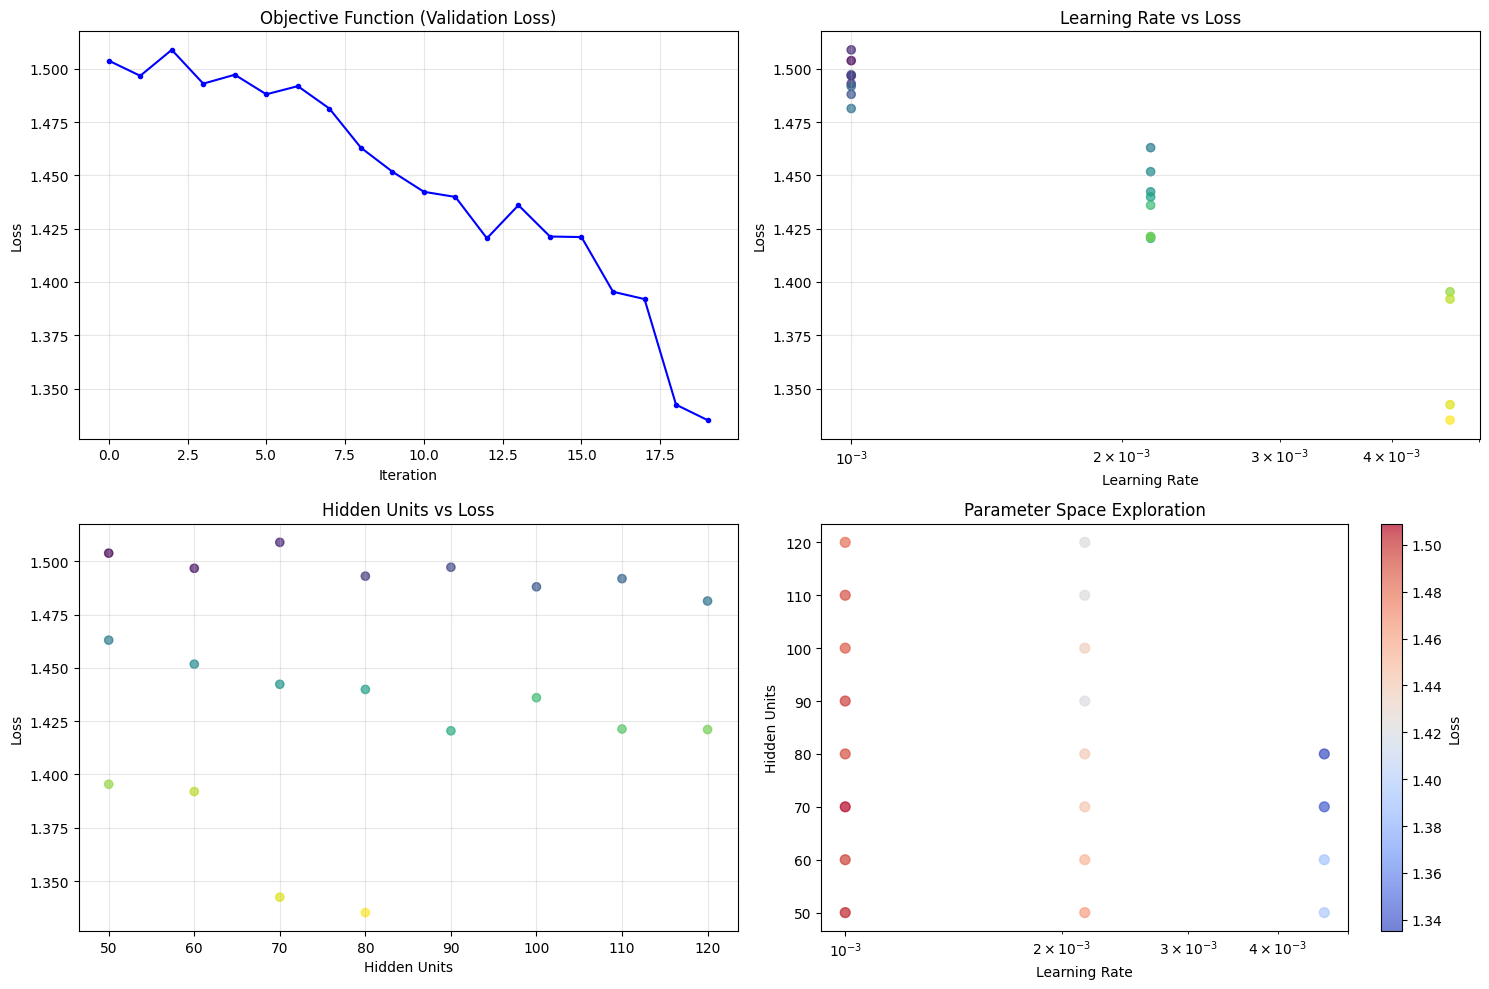

In [249]:
print("Bayesian Optimization for UniLSTM ===")
optimizer_uni=BayesianOptimizer(n_iterations=20, num_classes=5)
best_params_uni, best_loss_uni = optimizer_uni.optimize('uni', train_loader, val_loader)
print(f"\nBest parameters for UniLSTM: {best_params_uni}")
visualize_bayesian_optimization(optimizer_uni.history)

Bayesian Optimization for BiLSTM ===
Iteration 1/20: LR=0.0010, Hidden=50, Loss=1.4847
Iteration 2/20: LR=0.0010, Hidden=60, Loss=1.4787
Iteration 3/20: LR=0.0010, Hidden=70, Loss=1.4714
Iteration 4/20: LR=0.0010, Hidden=80, Loss=1.4632
Iteration 5/20: LR=0.0010, Hidden=90, Loss=1.4570
Iteration 6/20: LR=0.0010, Hidden=100, Loss=1.4637
Iteration 7/20: LR=0.0010, Hidden=110, Loss=1.4545
Iteration 8/20: LR=0.0010, Hidden=120, Loss=1.4440
Iteration 9/20: LR=0.0022, Hidden=50, Loss=1.4120
Iteration 10/20: LR=0.0022, Hidden=60, Loss=1.4091
Iteration 11/20: LR=0.0022, Hidden=70, Loss=1.3938
Iteration 12/20: LR=0.0022, Hidden=80, Loss=1.3858
Iteration 13/20: LR=0.0022, Hidden=90, Loss=1.3757
Iteration 14/20: LR=0.0022, Hidden=100, Loss=1.3547
Iteration 15/20: LR=0.0022, Hidden=110, Loss=1.3771
Iteration 16/20: LR=0.0022, Hidden=120, Loss=1.3524
Iteration 17/20: LR=0.0046, Hidden=50, Loss=1.2944
Iteration 18/20: LR=0.0046, Hidden=60, Loss=1.2884
Iteration 19/20: LR=0.0046, Hidden=70, Loss=1.27

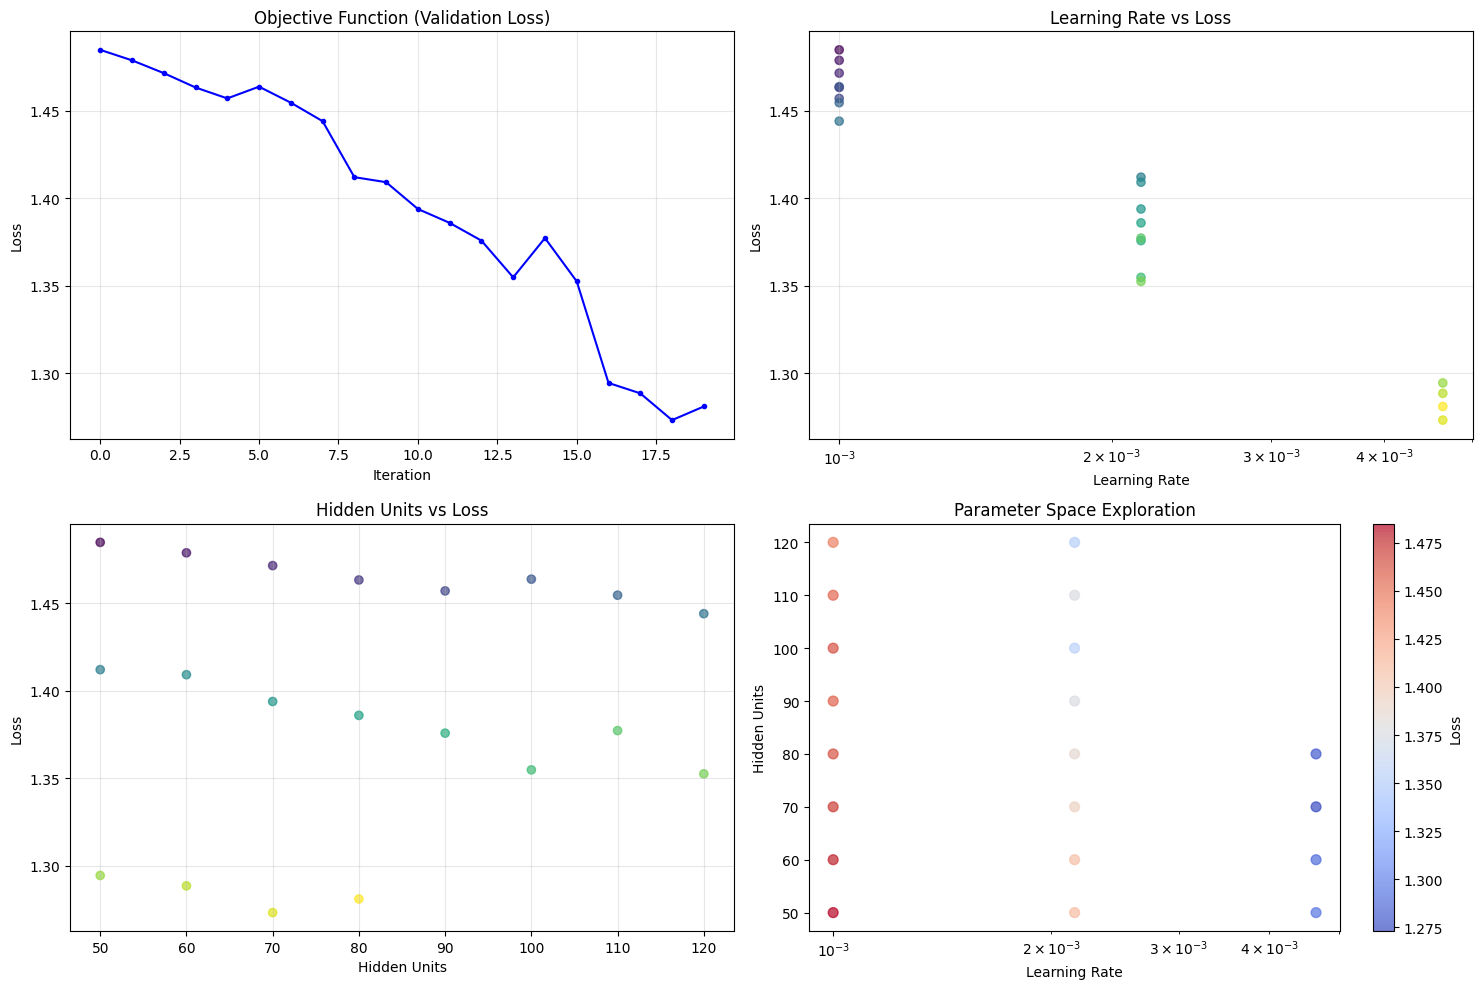

In [250]:
print("Bayesian Optimization for BiLSTM ===")
optimizer_bi=BayesianOptimizer(n_iterations=20, num_classes=5)
best_params_bi, best_loss_bi = optimizer_bi.optimize('bi', train_loader, val_loader)
print(f"\nBest parameters for BiLSTM: {best_params_bi}")
visualize_bayesian_optimization(optimizer_bi.history)

In [251]:
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, lr=0.001, epochs=80,patience=10):
    # Train and evaluate the model with extended metrics
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    print(f"Training {model.__class__.__name__}...")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        # --- Early stopping check ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Test evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_probs_per_class = [] # Changed to store probabilities for all classes

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            probs = torch.softmax(outputs, dim=1) # Probabilities for all classes
            _, predicted = torch.max(outputs.data, 1)

            all_probs_per_class.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate metrics for multiclass classification
    accuracy = accuracy_score(all_labels, all_preds)
    # Use 'weighted' average for precision, recall, f1 for multiclass imbalance
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)  # Sensitivity
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # For multiclass, sensitivity and specificity are often calculated per-class or averaged.
    # For simplicity, we will omit the single 'specificity' and 'balanced_accuracy'
    # metrics as they are binary-specific, and focus on overall multiclass metrics.
    # Balanced accuracy can be calculated with average='macro' or 'weighted' for multiclass accuracy_score, but sklearn's accuracy_score already has that functionality if desired.
    # For AUC, use 'ovr' (One-vs-Rest) strategy for multiclass and 'weighted' average.
    try:
        auc = roc_auc_score(all_labels, np.array(all_probs_per_class), multi_class='ovr', average='weighted')
        # roc_curve needs to be generated per-class for multiclass; for overall ROC, the AUC score is often sufficient.
        # Plotting multiclass ROC curves is more complex (e.g., one curve per class vs. rest).
        # For simplicity, we'll only plot one ROC curve (if a specific class vs rest is chosen or average).
        # To plot average ROC, we would need to aggregate FPR/TPR, which is not straightforward with roc_curve.
        # We will keep the AUC score as the primary metric for ROC for now.
        fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs_per_class)[:, 1], pos_label=1) # Example: ROC for class 1 vs rest
    except ValueError as e:
        print(f"Could not calculate ROC AUC or ROC curve: {e}")
        auc = np.nan
        fpr, tpr = [0, 1], [0, 1] # Fallback for plotting


    print(f"\nTest Results for {model.__class__.__name__}:")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")  # Average Recall (Sensitivity)
    print(f"F1-Score       : {f1:.4f}")
    print(f"AUC            : {auc:.4f}")

    # --- Visualization ---
    plt.figure(figsize=(15, 5))

    # Training curves
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model.__class__.__name__} Training Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confusion matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # Removed xticklabels/yticklabels for generic multiclass
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve - for simplicity, plotting AUC for now. Full multiclass ROC plotting is more involved.
    plt.subplot(1, 3, 3)
    if not np.isnan(auc):
        # For a single ROC curve in multiclass, you might pick one class vs. others or do a micro/macro average
        # This simplified plot for multiclass might not be perfectly representative of the weighted AUC.
        # A more robust multiclass ROC plotting would involve iterating through classes.
        plt.plot(fpr, tpr, label=f"Weighted AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model.__class__.__name__} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

Training BiLSTM...
Epoch [20/80], Train Loss: 1.1164, Val Loss: 1.0535
Epoch [40/80], Train Loss: 1.0348, Val Loss: 0.9938
Epoch [60/80], Train Loss: 0.9245, Val Loss: 0.9684
Early stopping at epoch 78

Test Results for BiLSTM:
Accuracy       : 0.5981
Precision      : 0.5980
Recall         : 0.5981
F1-Score       : 0.5925
AUC            : 0.8588


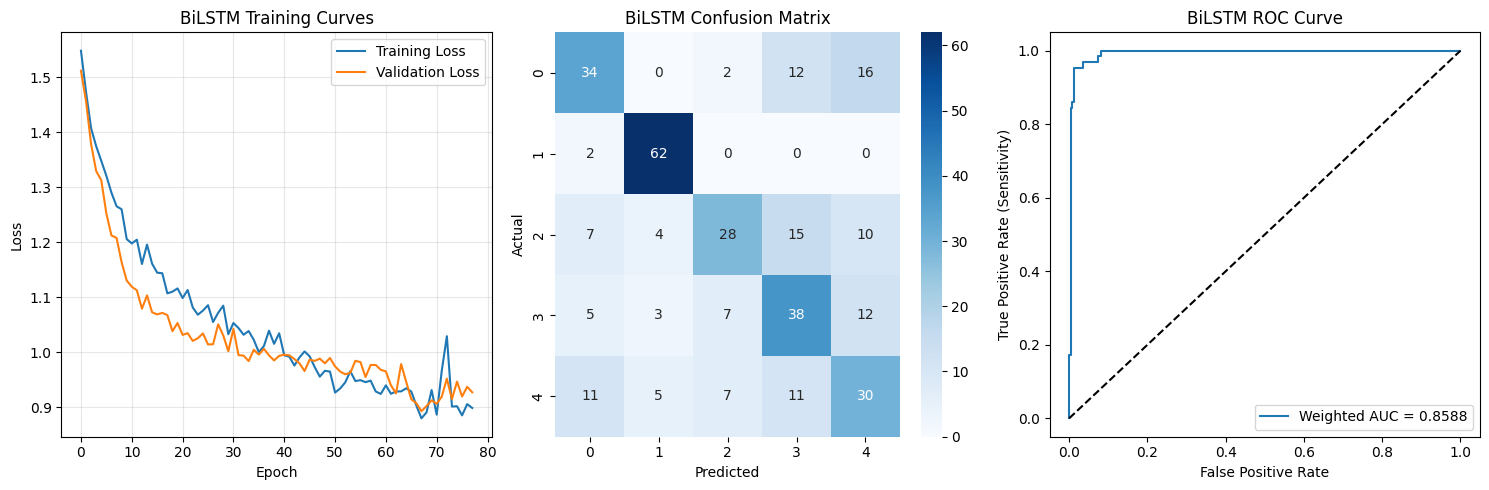

BiLSTM - Accuracy: 0.5981, F1: 0.5925


In [252]:
# training BiLSTM with optimized parameters
bi_model_grad= BiLSTM(input_size=4, hidden_size=best_params_bi['hidden_units'], num_classes=5)
bi_grad_results = train_and_evaluate_model(bi_model_grad, train_loader, val_loader, test_loader,
                                    lr=best_params_bi['lr'], epochs=80)
print(f"BiLSTM - Accuracy: {bi_grad_results['accuracy']:.4f}, F1: {bi_grad_results['f1']:.4f}")

Training UNILSTM Models ===
Training UniLSTM...
Epoch [20/80], Train Loss: 1.1572, Val Loss: 1.0752
Epoch [40/80], Train Loss: 1.0351, Val Loss: 1.0094
Epoch [60/80], Train Loss: 1.0558, Val Loss: 1.0003
Epoch [80/80], Train Loss: 0.9899, Val Loss: 0.9836

Test Results for UniLSTM:
Accuracy       : 0.5607
Precision      : 0.5837
Recall         : 0.5607
F1-Score       : 0.5627
AUC            : 0.8385


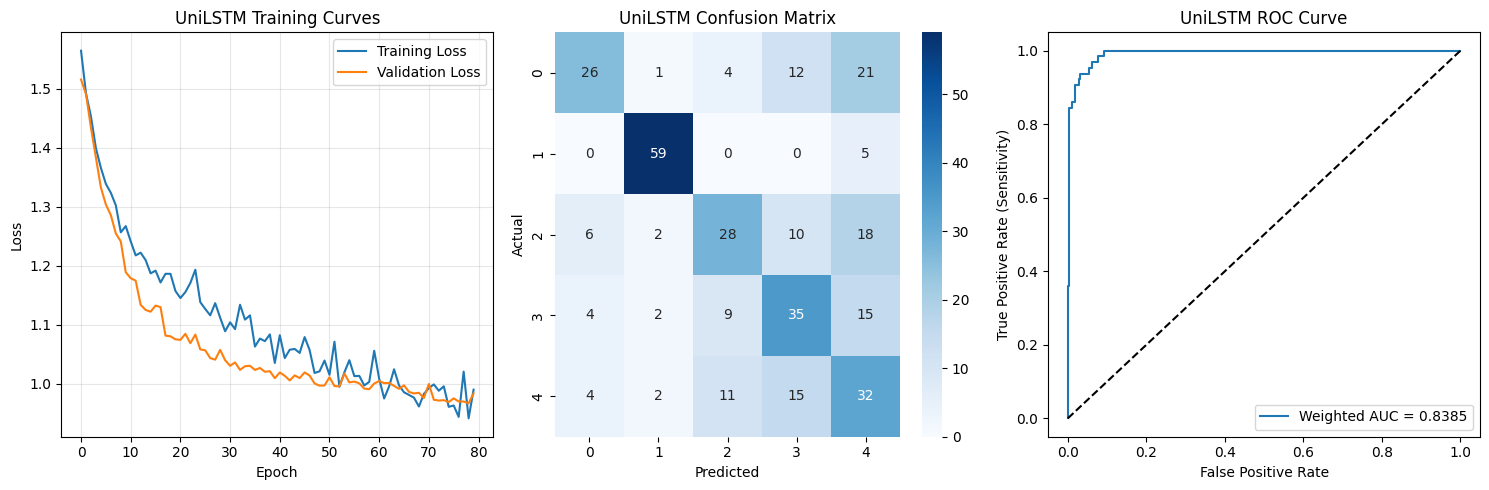

UniLSTM - Accuracy: 0.5607, F1: 0.5627


In [253]:
# Train LSTM models with optimized parameters
print("Training UNILSTM Models ===")

# UniLSTM with optimized parameters
bi_model_grad = UniLSTM(input_size=4, hidden_size=best_params_uni['hidden_units'], num_classes=5)
uni_grad_results = train_and_evaluate_model(bi_model_grad, train_loader, val_loader, test_loader,
                                      lr=best_params_uni['lr'], epochs=80)

print(f"UniLSTM - Accuracy: {uni_grad_results['accuracy']:.4f}, F1: {uni_grad_results['f1']:.4f}")
